# import das bibliotecas

In [8]:


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
from scipy import signal
from glob import glob
from scipy import stats


rcParams['figure.figsize'] = [16., 5.]

### Filtros

In [9]:
# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)

def butter_lowpass(data, lowcut, fs=200, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)

def butter_highpass(data, highcut, fs=200, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)

def butter_notch(data, cutoff, var=1, fs=200, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

### Carregando Dados

In [14]:
def plotData(dirs):
    data = np.load("datasets/topicos_cc/"+dirs)
    data = np.transpose(data, (0, 2, 1))
    print(data.shape)
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    for i in range(data_filtered.shape[1]):
        plt.plot(data_filtered[0,i,:])
    plt.suptitle(dirs)
    plt.show()
    
    


In [15]:
def loadSujeito(dirs):
    data = np.load("datasets/topicos_cc/"+dirs)
    data = np.transpose(data, (0, 2, 1))
    data_filtered = butter_notch(data, 60)
    data_filtered = butter_highpass(data_filtered, 5)
    data_filtered = butter_lowpass(data_filtered, 50)
    
    return data_filtered

In [16]:
data = []
for d in dirs:
    data.append(loadSujeito(d))

In [17]:
np.array(data).shape

(3, 8, 4, 1600)

### Visualizando

(8, 4, 1600)


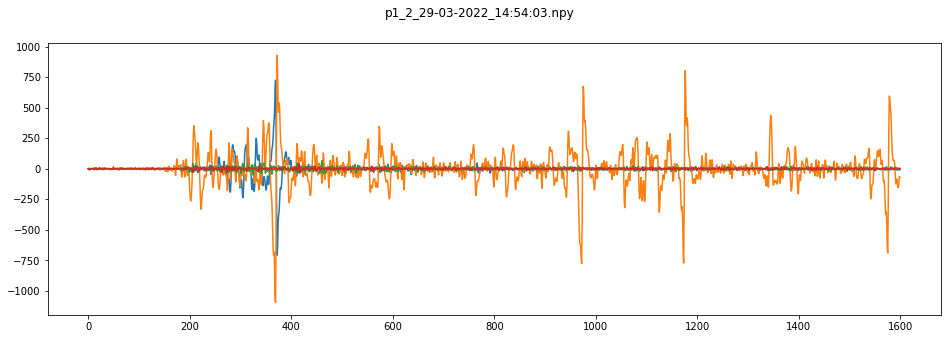

(8, 4, 1600)


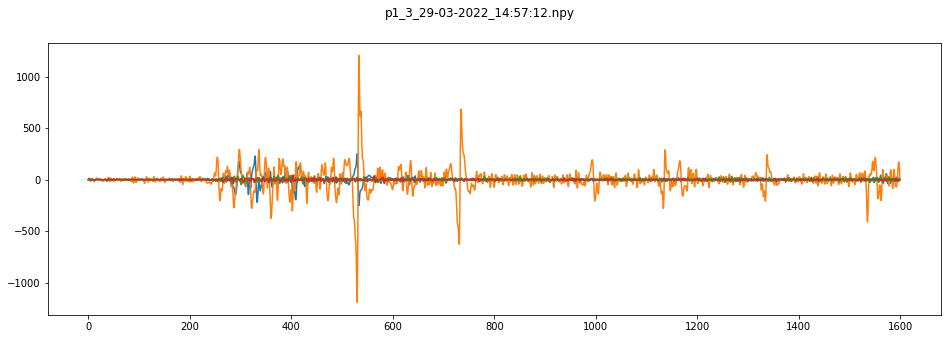

(8, 4, 1600)


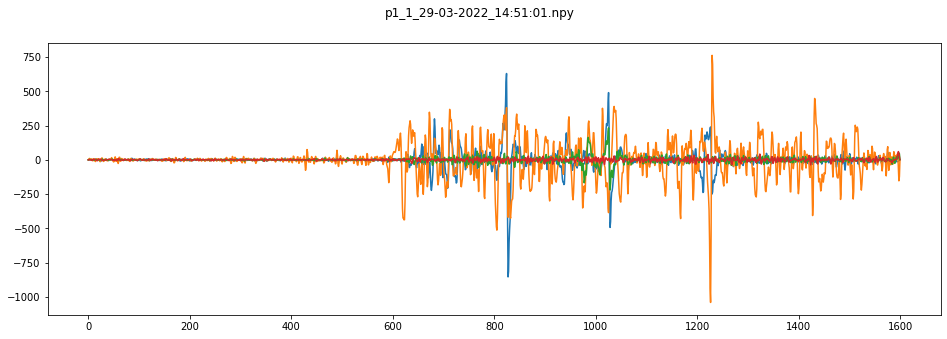

In [18]:
dirs = [ i.split("/")[-1] for i in glob('datasets/topicos_cc/p1*')]
for d in dirs:
    plotData(d)

# Concatenando Trials x Movimentos

In [19]:
import numpy as np

#X = data.reshape(24, 4, 1600)
X = np.concatenate((data), axis=0)
X.shape



(24, 4, 1600)

## Segmentação dos dados

In [20]:
from scipy.signal import stft

step = 58
segment = 128
data = X.reshape(24, 4, 1600)
print('', data.shape)

n_win = int((data.shape[-1] - segment) / step) + 1
ids = np.arange(n_win) * step

# Janelas do dado no dominio do tempo
chunks_time = np.array([data[:,:,k:(k + segment)] for k in ids]).transpose(1, 2, 0, 3)

# Janelas do dado no domínio da frequência
_, _, chunks_freq = stft(data, fs=200, nperseg=128, noverlap=64)
chunks_freq = np.swapaxes(chunks_freq, 2, 3)

print('Formato (shape) dos dados depois da divisão de janelas')
print(f'Dominio do tempo: {chunks_time.shape} - (classes+ensaios, canais, janelas, linhas)')
print(f'Dominio da frequência:  {chunks_freq.shape} - (classes+ensaios, canais, janelas, linhas)')

#sstft 200 128 64 .... 25 26 janelas
#Ajustar o step no dominio da frequência


#step = 470
#segment = 1024
#_, _, chunks_freq = stft(data, fs=4000, nperseg=1024, noverlap=512)



 (24, 4, 1600)
Formato (shape) dos dados depois da divisão de janelas
Dominio do tempo: (24, 4, 26, 128) - (classes+ensaios, canais, janelas, linhas)
Dominio da frequência:  (24, 4, 26, 65) - (classes+ensaios, canais, janelas, linhas)


## Extração e seleção de características

In [21]:
def getZC(data, th):
    tamanho = len(data)
    somatoria = 0
    
    for i in range(tamanho-1):
        resultado = (data[i] * data[i+1] )
        resultado2 = np.abs(data[i] - data[i+1])
        if(resultado < 0 ) and (resultado2 > th):
            somatoria += 1
        
    return somatoria

def fj(i, sampleRate, tamanho):
    return i * sampleRate / (2 * tamanho)

def getFMN(data):
    tamanho = len(data)
    somatoria = 0
    sumPSD = np.sum(PSD(data))
    for i in range(tamanho):
        somatoria += (fj(i, 41, tamanho) * PSD(data[i]) ) / sumPSD
        
    return somatoria



In [22]:
from math import prod

# funções auxiliares
def PSD(w):
    ''' definição da função PSD para o sinal no domínio da frequência '''
    return np.abs(w) ** 2

def wamp(x, th):
    res = np.abs(np.diff(x))
    return np.sum(res >= th, axis=-1)

def wl(x):
    res = np.abs(np.diff(x))
    return np.sum(res, axis=-1)

def var(x):
    return np.sum(x ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1)

def rms(x):
    return np.sqrt(np.sum(np.abs(x) ** 2, axis=-1) / (np.prod(x.shape[:-1]) - 1))

def fmd(w):
    return np.sum(PSD(w), axis=-1) / 2

def mmdf(w):
    return np.sum(np.abs(w), axis=-1) / 2

def zc(data,threshold):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                fy.append( getZC(data[xx][yy][zz], threshold ) )
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def fmn(data):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                
                fy.append( getFMN(data[xx][yy][zz]) )
                
            fx.append(fy)
        f.append(fx)
    return np.array(f)

def A(w):
    return np.abs(w)

def getMMNF(data):
    tamanho = len(data)
    somatoria = 0
    
    sumA = np.sum(A(data))
    
    for i in range(tamanho):
        somatoria += (fj(i, 200, tamanho) * A(data[i]) ) / sumA 
        
    return somatoria

def mmnf(data):
    f =[]
    x,y,z = data.shape[:3]
    for xx in range(x):
        fx = []
        for yy in range(y):
            fy = []
            for zz in range(z):
                
                fy.append( getMMNF(data[xx][yy][zz]) )
                
            fx.append(fy)
        f.append(fx)
    return np.array(f)


## Implementação do vetor

In [23]:
th = np.median(chunks_time)

In [24]:
final_data = list()
final_data.append(var(chunks_time))
final_data.append(rms(chunks_time))
final_data.append(wamp(chunks_time, th))
final_data.append(wl(chunks_time))
final_data.append(zc(chunks_time,0))

final_data.append(fmd(chunks_freq))
final_data.append(mmdf(chunks_freq))
final_data.append(fmn(chunks_freq))
final_data.append(mmnf(chunks_freq))

final = np.array(final_data)
final.shape

(9, 24, 4, 26)

In [25]:
data = final.transpose(1, 3, 2, 0)
X = data.reshape(data.shape[0]*data.shape[1], data.shape[2]*data.shape[3])
X.shape

(624, 36)

In [26]:
y = np.array(list(range(1, 9)) * int(X.shape[0] / 8))

## Seleção de características

In [27]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
VarianceThreshold = sel.fit_transform(X)
VarianceThreshold.shape

(624, 35)

## RFE

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.svm import SVC
estimator = SVC(kernel="linear")
selector = RFE(estimator, n_features_to_select=5, step=1)
selector = selector.fit(X, y)

In [ ]:
s = selector.fit_transform(X, y)